In [39]:
import catboost
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import shap
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error

### Import CatBoost Regressor and test data

In [22]:
catboost = joblib.load("../models/catboost_regression_model.joblib")
test_data = pd.read_csv("../data/feature_data/lgd_loan_data_test.csv")
test_target = test_data["LossGivenDefault"]
test_feature_data = test_data.drop(columns=["LossGivenDefault"])
y_pred = catboost.predict(test_feature_data)

### Lets visualize the LGD predictions vs the actual using a Scatter plot

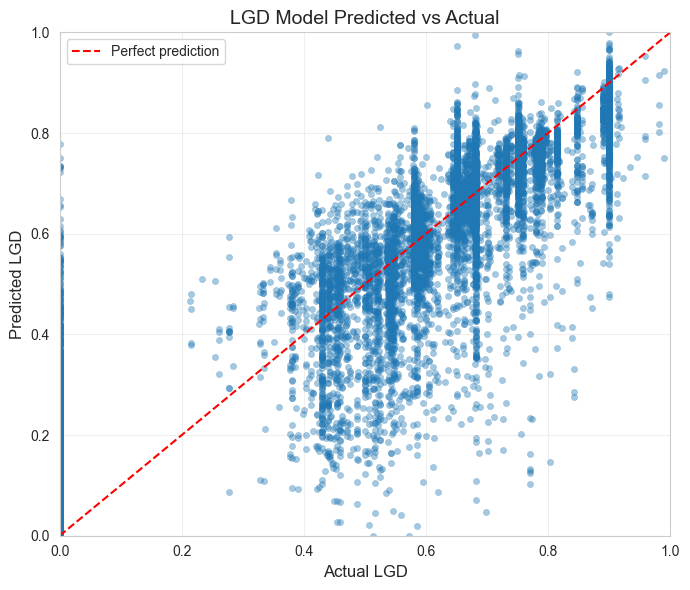

In [12]:
def plot_lgd_scatter(model, X_test, y_test, title="LGD Model Predicted vs Actual"):
    """
    Professional LGD scatter plot using seaborn.
    
    model  : trained CatBoostRegressor (or any regressor with .predict)
    X_test : test feature DataFrame/array
    y_test : true LGD values (array or Series, in [0,1])
    """
    # Predict
    y_pred = model.predict(X_test)
    
    # To be safe, clip to [0,1]
    y_true = np.clip(np.array(y_test), 0, 1)
    y_pred = np.clip(y_pred, 0, 1)

    df_plot = pd.DataFrame({
        "Actual_LGD": y_true,
        "Predicted_LGD": y_pred
    })

    # Figure
    plt.figure(figsize=(7, 6))
    sns.set_style("whitegrid")

    # Scatter with slight transparency
    sns.scatterplot(
        data=df_plot,
        x="Actual_LGD",
        y="Predicted_LGD",
        alpha=0.4,
        s=20,
        edgecolor=None
    )

    # 45-degree reference line
    line_min = 0
    line_max = 1
    plt.plot(
        [line_min, line_max],
        [line_min, line_max],
        linestyle="--",
        linewidth=1.5,
        color="red",
        label="Perfect prediction"
    )

    # Formatting
    plt.xlim(line_min, line_max)
    plt.ylim(line_min, line_max)
    plt.xlabel("Actual LGD", fontsize=12)
    plt.ylabel("Predicted LGD", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="upper left", frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_plot

df_plot = plot_lgd_scatter(catboost, test_feature_data, test_target)

### Model Calibration

In [23]:
sns.set(style="whitegrid")

def plot_lgd_calibration_seaborn(y_true, y_pred, bins=10, title="LGD Calibration Plot"):
    
    df = pd.DataFrame({
        "Actual LGD": y_true,
        "Predicted LGD": y_pred
    })

    # Create quantile buckets based on predicted LGD
    df["Bucket"] = pd.qcut(df["Predicted LGD"], bins, duplicates="drop")

    # Aggregate per bucket
    calib = df.groupby("Bucket").agg(
        MeanPred=("Predicted LGD", "mean"),
        MeanActual=("Actual LGD", "mean"),
        Count=("Actual LGD", "count")
    ).reset_index()

    # Plot
    plt.figure(figsize=(7, 6))

    sns.lineplot(
        data=calib,
        x="MeanPred",
        y="MeanActual",
        marker="o",
        linewidth=2,
        label="Model Calibration"
    )

    # Perfect calibration line
    x = np.linspace(0, max(calib["MeanPred"])*1.05, 100)
    plt.plot(x, x, "--", linewidth=1.5, label="Perfect Calibration")

    # Axis + title
    plt.xlabel("Mean Predicted LGD", fontsize=12)
    plt.ylabel("Observed LGD", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return calib

/var/folders/c0/ys9pkt156rd6jxylz86_1flh0000gn/T/ipykernel_4553/2324970874.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby("Bucket").agg(


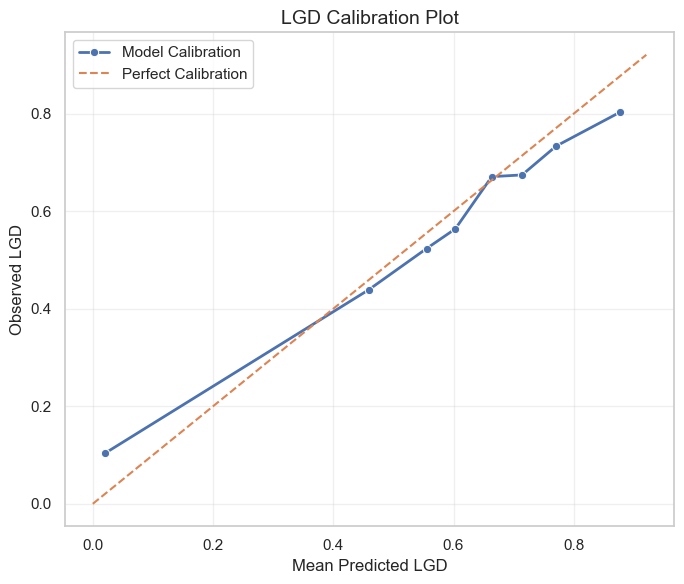

,Bucket,MeanPred,MeanActual,Count
0,"(-0.001, 0.403]",0.020813,0.104046,3289
1,"(0.403, 0.51]",0.458874,0.438822,1090
2,"(0.51, 0.58]",0.555105,0.523344,1407
3,"(0.58, 0.644]",0.603067,0.563850,835
4,"(0.644, 0.68]",0.663628,0.670830,1181
5,"(0.68, 0.75]",0.714095,0.674407,1149
6,"(0.75, 0.791]",0.770697,0.733497,895
7,"(0.791, 0.99]",0.876899,0.802974,1094


In [26]:
plot_lgd_calibration_seaborn(y_pred, test_target)

In [27]:
def plot_lgd_residuals_seaborn(y_true, y_pred, title="LGD Residual Plot"):
    
    residuals = y_true - y_pred

    df = pd.DataFrame({
        "Predicted LGD": y_pred,
        "Residual": residuals
    })

    plt.figure(figsize=(7, 6))

    sns.scatterplot(
        data=df,
        x="Predicted LGD",
        y="Residual",
        alpha=0.4,
        s=25
    )

    plt.axhline(0, linestyle="--", linewidth=1.5)

    plt.xlabel("Predicted LGD", fontsize=12)
    plt.ylabel("Residual (Actual − Predicted)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

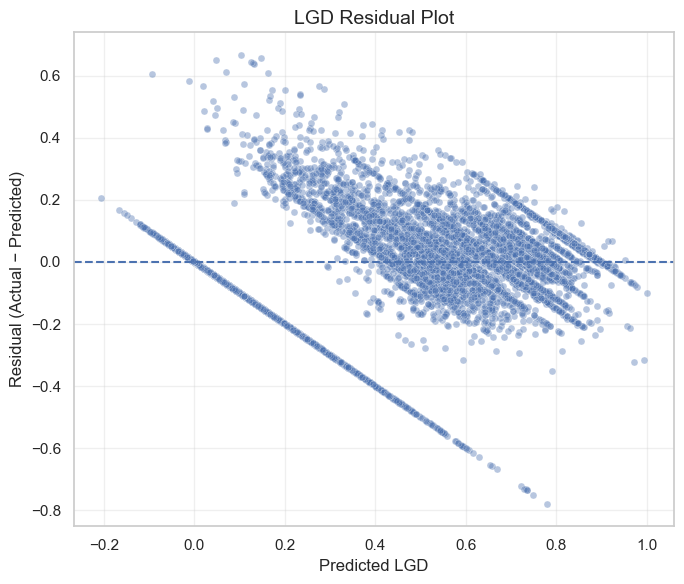

,Predicted LGD,Residual
0,0.620655,0.049836
1,0.777274,-0.018716
2,0.461115,0.198911
3,0.757263,-0.000383
4,0.405361,0.231053
...,...,...
10935,0.667843,0.232157
10936,0.756520,0.025572
10937,0.838359,0.061641
10938,0.770580,-0.020580


In [29]:
plot_lgd_residuals_seaborn(test_target, y_pred)

### Plotting Shap values

In [30]:
sns.set(style="whitegrid")

# Optional: sample for speed if test set is large
X_shap = test_feature_data.copy()
if len(X_shap) > 5000:
    X_shap = X_shap.sample(5000, random_state=42)

# Use TreeExplainer for CatBoost
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_shap)  # shape: [n_samples, n_features]

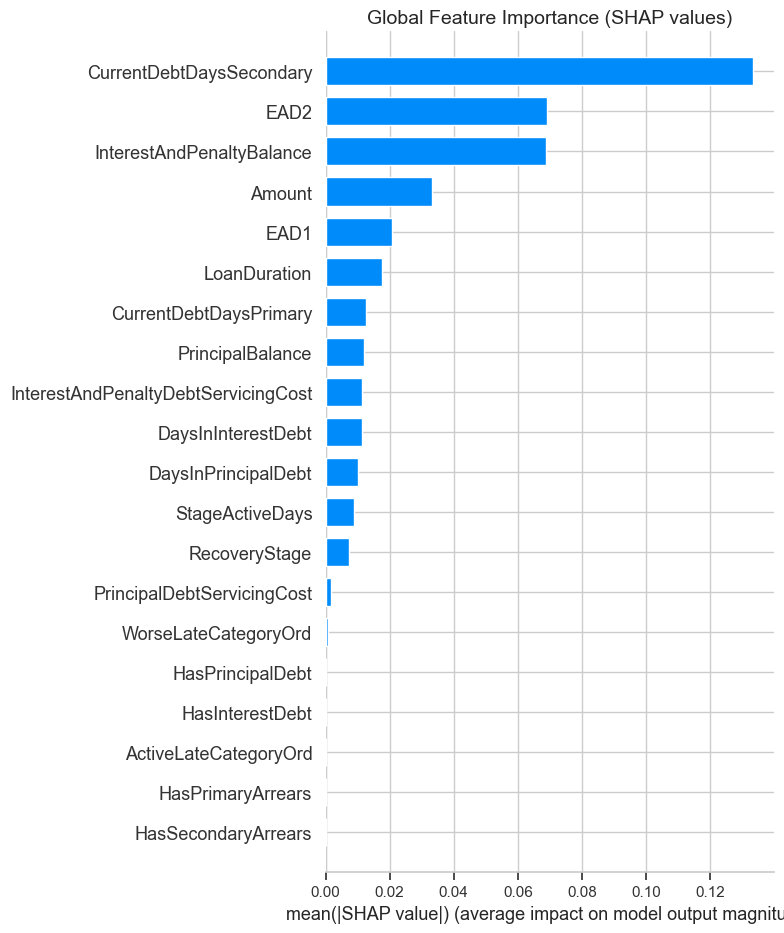

In [31]:
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("Global Feature Importance (SHAP values)", fontsize=14)
plt.tight_layout()
plt.show()

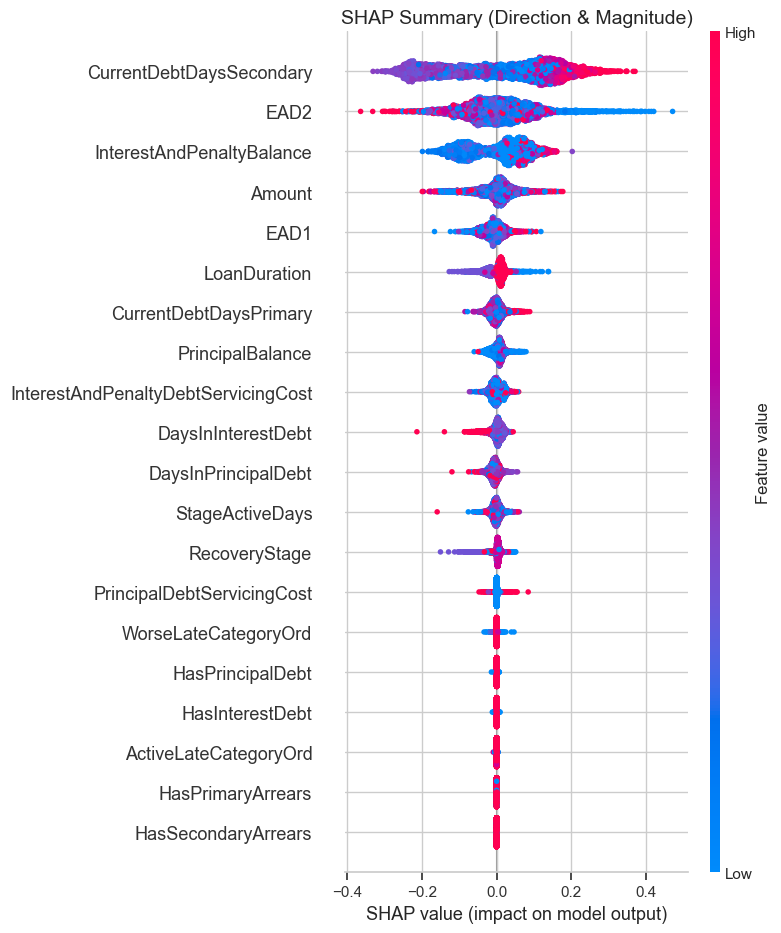

In [32]:
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    max_display=20,
    show=False
)
plt.title("SHAP Summary (Direction & Magnitude)", fontsize=14)
plt.tight_layout()
plt.show()

### Final Evaluation table 

In [40]:
def lgd_evaluation_table(y_true, y_pred, exposure=None, model_name="LGD Model"):
    """
    Create final evaluation table for LGD model
    """
    
    # Clip to [0,1] for safety
    y_true = np.clip(np.array(y_true), 0, 1)
    y_pred = np.clip(np.array(y_pred), 0, 1)

    # Core metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman = spearmanr(y_true, y_pred).correlation
    pearson = pearsonr(y_true, y_pred)[0]

    results = {
        "Model": model_name,
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R²": round(r2, 4),
        "Spearman Corr": round(spearman, 4),
        "Pearson Corr": round(pearson, 4)
    }

    # Exposure-weighted MAE (if provided)
    if exposure is not None:
        exposure = np.array(exposure)
        wmae = np.average(np.abs(y_true - y_pred), weights=exposure)
        results["Weighted MAE"] = round(wmae, 4)

    return pd.DataFrame([results])

In [42]:
eval_table = lgd_evaluation_table(
    y_true=test_target,
    y_pred=y_pred,
    model_name="CatBoost LGD"
)
eval_table

,Model,MAE,RMSE,R²,Spearman Corr,Pearson Corr
0,CatBoost LGD,0.082,0.1279,0.836,0.8994,0.9146
